In [1]:
import numpy as np
import tensorflow as tf
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [2]:
seizure_type = "absence"
model_type = "default"

model_path = f"model/tflite_models/{seizure_type}.tflite"
main_folder_path = "melspectrograms/"
path = main_folder_path + seizure_type + "/"

test_x = np.load(f"{path}/test_{seizure_type}_x.npy")
test_y = np.load(f"{path}/test_{seizure_type}_y.npy")

In [3]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]["shape"]

In [4]:
test_x = np.expand_dims(test_x, axis=1)
print(test_x.shape)

(559, 1, 40, 26)


In [5]:
# Input size
print("Input Shape:", input_shape)

Input Shape: [ 1  1 40 26]


# Inference


In [6]:
tp, tn, fp, fn = 0, 0, 0, 0
actual, predicted = [], []
comb_actual, comb_predicted = [], []

for i, v in enumerate(test_x):
    v = np.uint8(v)
    v = np.expand_dims(v, axis=0)
    interpreter.set_tensor(input_details[0]["index"], v)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]["index"])

    output_zeropoint = output_details[0]["quantization"][1]
    output_scale = output_details[0]["quantization"][0]

    output_data_0 = (output_data[0][0] - output_zeropoint) * output_scale
    output_data_1 = (output_data[0][1] - output_zeropoint) * output_scale

    output_data = [output_data_0, output_data_1]

    output_data = tf.nn.softmax(output_data)

    actual.append(test_y[i])
    predicted.append(output_data)

    # print(output_data, test_y[i])
    if output_data[1] > output_data[0]:
        if test_y[i] == 1:
            tp += 1
        else:
            fp += 1
    else:
        if test_y[i] == 0:
            tn += 1
        else:
            fn += 1

In [7]:
y_true = []
y_score = []

# print(len(comb_actual), len(comb_predicted))

# for i in range(len(comb_actual)):
#     y_true.append(comb_actual[i])
#     y_score.append(comb_predicted[i].cpu().numpy())

# for i, v in enumerate(y_true):
#     if v == 0:
#         y_true[i] = 0
#     elif v == 1:
#         y_true[i] = 1
#     elif v == 2:
#         y_true[i] = 2
#     else:
#         y_true[i] = 3

# for i, v in enumerate(y_score):
#     a = max(v)
#     for m, j in enumerate(v):
#         if j == a:
#             if m == 0:
#                 y_score[i] = 0
#             elif m == 1:
#                 y_score[i] = 1
#             elif m == 2:
#                 y_score[i] = 2
#             else:
#                 y_score[i] = 3

# y_true = np.array(y_true)
# y_score = np.array(y_score)

# Binary Class Results


In [14]:
if seizure_type != "combined":
    print(seizure_type)

    sensitivity = (tp) / (tp + fn)

    specificity = (tn) / (tn + fp)

    precision = (tp) / (tp + fp)

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    gmean = math.sqrt(sensitivity * specificity)

    print("Confusion Matrix:")
    print(
        f"""

        ////                 Is Seizure, Is Not Seizure

        Is Seizure           {tp} ({round(tp/(tp + tn + fp + fn),2)*100}%)   {fp}({round(fp/(tp + tn + fp + fn),2)*100}%)

        Is Not Seizure       {fn} ({round(fn/(tp + tn + fp + fn),2)*100}%)   {tn}({round(tn/(tp + tn + fp + fn),2)*100}%)


        Accuracy: {accuracy*100}

        Sensitivity: {sensitivity*100}, ({tp}, {tp + fn})

        Specificity: {specificity*100}, ({tn}, {tn + fp})

        GMEAN: {gmean*100}
        """
    )
print(tp + tn + fp + fn)

absence
Confusion Matrix:


        ////                 Is Seizure, Is Not Seizure

        Is Seizure           18 (3.0%)   0(0.0%)

        Is Not Seizure       2 (0.0%)   539(96.0%)


        Accuracy: 99.6422182468694

        Sensitivity: 90.0, (18, 20)

        Specificity: 100.0, (539, 539)

        GMEAN: 94.86832980505137
        
559


In [9]:
y_score = []
y_pred = []
for i in predicted:
    y_score.append(i[1].numpy())
    if i[1] > i[0]:
        y_pred.append(1)
    else:
        y_pred.append(0)

print(y_score)

[0.0010113065399781844, 0.0014764654276307855, 0.005333200292112685, 0.0013688678734191352, 0.00476292778506542, 0.9954133390834402, 0.00513593763748421, 0.23604105421511187, 0.00047427556591356885, 0.0012219757514473964, 0.0032657587265105172, 0.0015925070192829506, 0.0009737441727706152, 0.001852615486945506, 0.001998161125197854, 0.0013180423370082307, 0.000805835677580258, 0.0040958862275625235, 0.0017176531163465385, 0.0010113065399781844, 0.008068429198946922, 0.0011765978368778267, 0.0007470737631259428, 0.0010113065399781844, 0.009030883080086854, 0.0014216505228715401, 0.0010908292879914297, 0.0009375756532050708, 0.004416888397918091, 0.003944207461804809, 0.0010908292879914297, 0.0072078014522651114, 0.0008692155550094555, 0.0014764654276307855, 0.001998161125197854, 0.002324371921759155, 0.0021551164678645382, 0.0021551164678645382, 0.013636536638573017, 0.0013688678734191352, 0.0021551164678645382, 0.0019240151899923717, 0.0029159071145982017, 0.0040958862275625235, 0.0011

In [10]:
cm = metrics.confusion_matrix(actual, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
sensitivity = cm[1][1] / (cm[1][1] + cm[1][0])
print(f"Sensitivity: {sensitivity}")

specificity = cm[0][0] / (cm[0][0] + cm[0][1])
print(f"Specificity: {specificity}")

Confusion Matrix:
[[539   0]
 [  2  18]]
Classification Report:
Sensitivity: 0.9
Specificity: 1.0


In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y_true=actual, y_score=y_score)
roc_auc = metrics.auc(fpr, tpr)

In [16]:
print("ROC AUC:", roc_auc * 100)

ROC AUC: 98.20964749536178


In [13]:
row = [
    [
        seizure_type,
        round(accuracy * 100, 2),
        round(sensitivity * 100, 2),
        round(specificity * 100, 2),
        round(precision * 100, 2),
        round(gmean * 100, 2),
        round(roc_auc * 100, 2),
    ]
]


df = pd.DataFrame(
    row,
    columns=[
        "seizure_type",
        "accuracy",
        "sensitivity",
        "specificity",
        "precision",
        "roc_auc",
        "gmean",
    ],
)

In [23]:
df

,seizure_type,accuracy,sensitivity,specificity,precision,roc_auc,gmean
0,absence,99.64,90.0,100.0,100.0,94.87,98.79


In [ ]:
# df.to_csv(f"results/tflite_inference/{seizure_type}/{seizure_type}_tflite_results.csv")

# Multi-Class Results


In [34]:
labels = ["Background", "Absence", "Tonic-Clonic", "General"]
cm = metrics.confusion_matrix(y_true, y_score)

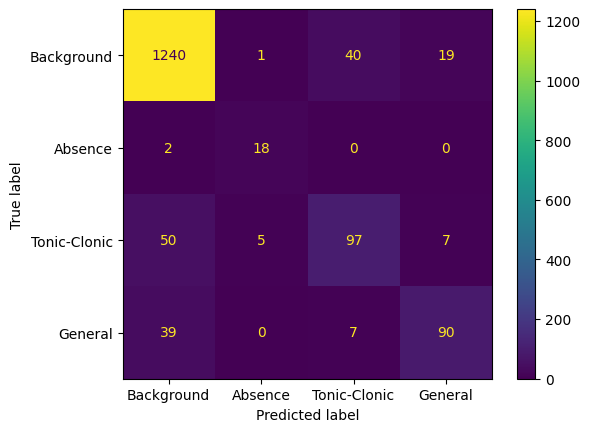

In [35]:
a = metrics.ConfusionMatrixDisplay(cm, display_labels=labels)
a.plot()
a.figure_.savefig(f"results/pytorch_inference/default/combined/combined_cm.png")

In [36]:
background_tp = cm[0][0]
background_fp = cm[1][0] + cm[2][0] + cm[3][0]
background_fn = cm[0][1] + cm[0][2] + cm[0][3]
background_tn = len(y_true) - (background_tp + background_fp + background_fn)

print(
    f"Background // TP: {background_tp} // FP: {background_fp} // FN: {background_fn} // TN: {background_tn} // Total: {background_tp + background_fp + background_fn + background_tn}"
)

background_accuracy = (background_tp + background_tn) / (
    background_tp + background_fp + background_fn + background_tn
)
background_sensitivity = background_tp / (background_tp + background_fn)
background_specificity = background_tn / (background_tn + background_fp)
background_precision = background_tp / (background_tp + background_fp)
background_gmean = np.sqrt(background_sensitivity * background_specificity)

print(
    f"Accuracy: {background_accuracy} // Sensitivity: {background_sensitivity} // Specificity: {background_specificity} // Precision: {background_precision} // G-Mean: {background_gmean}"
)

Background // TP: 1240 // FP: 91 // FN: 60 // TN: 224 // Total: 1615
Accuracy: 0.9065015479876161 // Sensitivity: 0.9538461538461539 // Specificity: 0.7111111111111111 // Precision: 0.9316303531179564 // G-Mean: 0.8235839958927069


In [37]:
absence_tp = cm[1][1]
absence_fp = cm[0][1] + cm[2][1] + cm[3][1]
absence_fn = cm[1][0] + cm[1][2] + cm[1][3]
absence_tn = len(y_true) - (absence_tp + absence_fp + absence_fn)

print(
    f"Absence // TP: {absence_tp} // FP: {absence_fp} // FN: {absence_fn} // TN: {absence_tn} // Total: {absence_tp + absence_fp + absence_fn + absence_tn}"
)

absence_accuracy = (absence_tp + absence_tn) / (
    absence_tp + absence_fp + absence_fn + absence_tn
)
absence_sensitivity = absence_tp / (absence_tp + absence_fn)
absence_specificity = absence_tn / (absence_tn + absence_fp)
absence_precision = absence_tp / (absence_tp + absence_fp)
absence_gmean = np.sqrt(absence_sensitivity * absence_specificity)

print(
    f"Accuracy: {absence_accuracy} // Sensitivity: {absence_sensitivity} // Specificity: {absence_specificity} // Precision: {absence_precision} // G-Mean: {absence_gmean}"
)

Absence // TP: 18 // FP: 6 // FN: 2 // TN: 1589 // Total: 1615
Accuracy: 0.9950464396284829 // Sensitivity: 0.9 // Specificity: 0.9962382445141066 // Precision: 0.75 // G-Mean: 0.9468972595074377


In [38]:
tonic_clonic_tp = cm[2][2]
tonic_clonic_fp = cm[0][2] + cm[1][2] + cm[3][2]
tonic_clonic_fn = cm[2][0] + cm[2][1] + cm[2][3]
tonic_clonic_tn = len(y_true) - (tonic_clonic_tp + tonic_clonic_fp + tonic_clonic_fn)

print(
    f"Tonic-Clonic // TP: {tonic_clonic_tp} // FP: {tonic_clonic_fp} // FN: {tonic_clonic_fn} // TN: {tonic_clonic_tn} // Total: {tonic_clonic_tp + tonic_clonic_fp + tonic_clonic_fn + tonic_clonic_tn}"
)

tonic_clonic_accuracy = (tonic_clonic_tp + tonic_clonic_tn) / (
    tonic_clonic_tp + tonic_clonic_fp + tonic_clonic_fn + tonic_clonic_tn
)
tonic_clonic_sensitivity = tonic_clonic_tp / (tonic_clonic_tp + tonic_clonic_fn)
tonic_clonic_specificity = tonic_clonic_tn / (tonic_clonic_tn + tonic_clonic_fp)
tonic_clonic_precision = tonic_clonic_tp / (tonic_clonic_tp + tonic_clonic_fp)
tonic_clonic_gmean = np.sqrt(tonic_clonic_sensitivity * tonic_clonic_specificity)

print(
    f"Accuracy: {tonic_clonic_accuracy} // Sensitivity: {tonic_clonic_sensitivity} // Specificity: {tonic_clonic_specificity} // Precision: {tonic_clonic_precision} // G-Mean: {tonic_clonic_gmean}"
)

Tonic-Clonic // TP: 97 // FP: 47 // FN: 62 // TN: 1409 // Total: 1615
Accuracy: 0.9325077399380804 // Sensitivity: 0.610062893081761 // Specificity: 0.9677197802197802 // Precision: 0.6736111111111112 // G-Mean: 0.7683553401996533


In [39]:
general_tp = cm[3][3]
general_fp = cm[0][3] + cm[1][3] + cm[2][3]
general_fn = cm[3][0] + cm[3][1] + cm[3][2]
general_tn = len(y_true) - (general_tp + general_fp + general_fn)

print(
    f"General // TP: {general_tp} // FP: {general_fp} // FN: {general_fn} // TN: {general_tn} // Total: {general_tp + general_fp + general_fn + general_tn}"
)

general_accuracy = (general_tp + general_tn) / (
    general_tp + general_fp + general_fn + general_tn
)
general_sensitivity = general_tp / (general_tp + general_fn)
general_specificity = general_tn / (general_tn + general_fp)
general_precision = general_tp / (general_tp + general_fp)
general_gmean = np.sqrt(general_sensitivity * general_specificity)

print(
    f"Accuracy: {general_accuracy} // Sensitivity: {general_sensitivity} // Specificity: {general_specificity} // Precision: {general_precision} // G-Mean: {general_gmean}"
)

General // TP: 90 // FP: 26 // FN: 46 // TN: 1453 // Total: 1615
Accuracy: 0.9554179566563468 // Sensitivity: 0.6617647058823529 // Specificity: 0.982420554428668 // Precision: 0.7758620689655172 // G-Mean: 0.8063071680533824


In [40]:
background_roc_auc, absence_roc_auc, tonic_clonic_roc_auc, general_roc_auc = 0, 0, 0, 0

background_row = [
    [
        "background",
        round(background_accuracy * 100, 3),
        round(background_sensitivity * 100, 3),
        round(background_specificity * 100, 3),
        round(background_precision * 100, 3),
        round(background_gmean * 100, 3),
        f"{background_tp} / {background_fn} / {background_tn} / {background_fp}",
    ]
]

absence_row = [
    [
        "absence",
        round(absence_accuracy * 100, 3),
        round(absence_sensitivity * 100, 3),
        round(absence_specificity * 100, 3),
        round(absence_precision * 100, 3),
        round(absence_gmean * 100, 3),
        f"{absence_tp} / {absence_fn} / {absence_tn} / {absence_fp}",
    ]
]

tonic_clonic_row = [
    [
        "tonic-clonic",
        round(tonic_clonic_accuracy * 100, 3),
        round(tonic_clonic_sensitivity * 100, 3),
        round(tonic_clonic_specificity * 100, 3),
        round(tonic_clonic_precision * 100, 3),
        round(tonic_clonic_gmean * 100, 3),
        f"{tonic_clonic_tp} / {tonic_clonic_fn} / {tonic_clonic_tn} / {tonic_clonic_fp}",
    ]
]

general_row = [
    [
        "general",
        round(general_accuracy * 100, 3),
        round(general_sensitivity * 100, 3),
        round(general_specificity * 100, 3),
        round(general_precision * 100, 3),
        round(general_gmean * 100, 3),
        f"{general_tp} / {general_fn} / {general_tn} / {general_fp}",
    ]
]


df = pd.DataFrame(
    background_row + absence_row + tonic_clonic_row + general_row,
    columns=[
        "Seizure Type",
        "Accuracy",
        "Sensitivity",
        "Specificity",
        "Precision",
        "G-Mean",
        "TP / FN / TN / FP",
    ],
)

In [41]:
df

,Seizure Type,Accuracy,Sensitivity,Specificity,Precision,G-Mean,TP / FN / TN / FP
0,background,90.650,95.385,71.111,93.163,82.358,1240 / 60 / 224 / 91
1,absence,99.505,90.000,99.624,75.000,94.690,18 / 2 / 1589 / 6
2,tonic-clonic,93.251,61.006,96.772,67.361,76.836,97 / 62 / 1409 / 47
3,general,95.542,66.176,98.242,77.586,80.631,90 / 46 / 1453 / 26


In [42]:
df.to_csv(f"results/tflite_inference/combined/combined_pytorch_results.csv")